<a href="https://colab.research.google.com/github/yunbin03/AI-model-to-detect-medical-ins-urance-fraud/blob/main/claim_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 코랩 환경 초기 설정 // !pip는 필요한 특정 라이브러리를 설치하는 명령어
!pip install pandas matplotlib seaborn scikit-learn xgboost imbalanced-learn  kaggle numpy

# 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # 학습용 데이터랑 테스트용 데이터랑 나누는 작업, 과적합 방지를 위함
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # 모델 성능을 텍스트 형식으로 보여주는 것
#오버샘플링
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler # 데이터 값들끼리 차이가 클 때 스케일링으로 규모 차이를 줄여주는 역할하는 것
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 데이터셋 CSV 파일 읽기 // df: 데이터 프레임의 약자 그리고 이건 테이블 형식이다. 데이터 읽기는 테이블형식으로 가능함
#df = pd.read_csv("medical_aid_claims.csv",  sep = ",")

# 드라이브에서 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv('/content/drive/MyDrive/medical_aid_claims.csv')


Mounted at /content/drive


In [ ]:
df.shape # 데이터 크기 알기
# df.head() # 데이터 상위 3줄 보여주기

(7000, 15)

In [ ]:
# 결측값 찾기
df.isna().sum()

,0
member-name,0
email,0
gender,0
location,0
employer,0
relationship,0
patient_name,0
patient_suffix,0
patient_dob,0
cause,0


In [ ]:
# 칼럼에 있는 값들 개수
for _ in df.columns:
  print(df[_].value_counts())

member-name
Konde          318
Sithole        314
Gweta          313
Evans          306
Sibanda        303
Chisa          302
Chipi          298
Chisa Chisi    297
Chiri          295
Femba          293
Geta           292
Dihwa          290
Tichaona       290
Mabhena        289
Moyo           285
Mirwa          284
Nyoni          283
Peterson       283
Foto           282
Jembwa         281
Gute           281
Samvura        275
Gura           275
Bima           271
Name: count, dtype: int64
email
ajimmison0@sun.com              1
bastonif@geocities.com          1
smcmoniesiq@biblegateway.com    1
mhalewoodip@phoca.cz            1
rplumbleyio@usda.gov            1
                               ..
gmorlon95@economist.com         1
mforster94@newyorker.com        1
jmatson93@ning.com              1
pfenemore92@facebook.com        1
wlantrr@quantcast.com           1
Name: count, Length: 7000, dtype: int64
gender
male      3584
female    3416
Name: count, dtype: int64
location
Marondera    6

In [ ]:
# --- 데이터 전처리 ---
# 'patient_dob'
from datetime import datetime
df['age'] = datetime.now().year - pd.to_datetime(df['patient_dob']).dt.year

# 'Fee Charged'를 'fee_charged'로 변경
df = df.rename(columns={'Fee Charged': 'fee_charged'})

# 학습에 사용할 특징 선택
#features = ['gender', 'location', 'age', 'cause', 'Fee Charged', 'membership_period', 'number_of_claims', 'number_of_dependants']
# location제거
features = ['gender', 'age', 'cause', 'fee_charged', 'membership_period', 'number_of_claims', 'number_of_dependants']

# 원-핫 인코딩으로 범주형 변수 처리 // 성별, 지역, 병명은 문자열 데이터로 원핫 인코딩을 통해 숫자형 데이터로 변경해주기
X = df[features] # X값에 특징 저장
#X = pd.get_dummies(X, columns=['gender', 'location', 'cause'], drop_first=True)
X = pd.get_dummies(X, columns=['gender', 'cause'], drop_first=True)

# Y값에 사기여부를 저장
y = df['label']

#이상치
def get_outlier(df=None, column=None, weight=1.5):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values,25)
    quantile_75 = np.percentile(df[column].values,75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
    return outlier_idx

    outlier_idx = get_outlier(df=df, column='Fee Charged', weight=1.5)
    df.drop(outlier_idx, axis=0, inplace=True)

# 데이터 분할 // 80%는 학습용, 20%는 테스트용으로 분할하여 과적합 방지 random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)

# Scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaling using MinMaxScaler
minmax_scale = MinMaxScaler()
X_train_scaled = minmax_scale.fit_transform(X_train)
X_test_scaled = minmax_scale.transform(X_test)

# 2-dimensional reduction principal component analysis pca
pca = PCA(n_components=2)
pca.fit(X_train_scaled)
pca.fit(X_test_scaled)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#print(X_train_pca.shape)
#print(X_test_pca.shape)


In [ ]:
X_train_scaled.shape

(5600, 9)

In [ ]:
# 데이터 불균형 해소 (사기 청구 데이터 수가 너무 적어서)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#df[features] # 사용할 데이터 열만 가지고 테이블화


In [ ]:
df.head()

,member-name,email,gender,location,employer,relationship,patient_name,patient_suffix,patient_dob,cause,fee_charged,membership_period,number_of_claims,number_of_dependants,label,age
0,Chipi,ajimmison0@sun.com,female,Kwekwe,Vipe,Grandfather,Mabhena,789,9/11/1997,Other,3798,1541,2,4,0,27
1,Femba,rsoonhouse1@google.it,female,Marondera,Mudo,Husband,Sithole,860,1/14/1992,Other,48905,8269,4,3,0,32
2,Geta,bchecchetelli2@house.gov,female,Rusape,Skaboo,Mother,Chipi,374,7/3/1999,Road Traffic Accident,39963,6223,2,2,0,25
3,Tichaona,mgarman3@psu.edu,female,Rusape,Babbleset,Father,Jembwa,729,7/31/1978,Road Traffic Accident,34948,8832,6,3,0,46
4,Chisa,ccough4@biglobe.ne.jp,female,Bulawayo,Flipopia,Father,Foto,716,12/28/1992,Accident At Work,46984,8804,1,2,1,32


In [ ]:
# 기초통계량 확인
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_suffix,7000.0,549.738857,259.634041,100.0,323.00,549.0,777.00,999.0
Fee Charged,7000.0,25464.071429,14336.311377,503.0,12864.25,25469.0,37870.75,49998.0
membership_period,7000.0,4521.435143,2576.064241,100.0,2298.75,4485.0,6752.25,9000.0
number_of_claims,7000.0,3.448000,1.707378,1.0,2.00,3.0,5.00,6.0
number_of_dependants,7000.0,2.479000,1.119704,1.0,1.00,2.0,3.00,4.0
label,7000.0,0.197000,0.397761,0.0,0.00,0.0,0.00,1.0
age,7000.0,36.944286,12.974065,14.0,26.00,37.0,48.00,59.0


**gender**

"male":1, "female":2

**location**

"Bindura":1, "Bulawayo":2, "Gwanda":3, "Gweru":4, "Harare":5,"Kadoma":6, "Kwekwe":7, "Marondera":8, "Masvingo":9, "Mutare":10,"Nyanga":11, "Rusape":12

**cause**

"Accident At Home":1, "Accident At Work":2, "Road Traffic Accident":3, "Other":4

In [ ]:
# Ordinal Encoding 'gender', 'location', 'cause'
gender_map = {"male":1, "female":2 }
df["gender"] = df["gender"].map(gender_map)

#location_map = {"Bindura":1, "Bulawayo":2, "Gwanda":3, "Gweru":4, "Harare":5,
#                "Kadoma":6, "Kwekwe":7, "Marondera":8, "Masvingo":9, "Mutare":10,
#               "Nyanga":11, "Rusape":12 }

#df["location"] = df["location"].map(location_map)


cause_map = {"Accident At Home":1, "Accident At Work":2, "Road Traffic Accident":3,
             "Other":4}
df["cause"] = df["cause"].map(cause_map)

df.head()

,member-name,email,gender,location,employer,relationship,patient_name,patient_suffix,patient_dob,cause,fee_charged,membership_period,number_of_claims,number_of_dependants,label,age
0,Chipi,ajimmison0@sun.com,2,Kwekwe,Vipe,Grandfather,Mabhena,789,9/11/1997,4,3798,1541,2,4,0,27
1,Femba,rsoonhouse1@google.it,2,Marondera,Mudo,Husband,Sithole,860,1/14/1992,4,48905,8269,4,3,0,32
2,Geta,bchecchetelli2@house.gov,2,Rusape,Skaboo,Mother,Chipi,374,7/3/1999,3,39963,6223,2,2,0,25
3,Tichaona,mgarman3@psu.edu,2,Rusape,Babbleset,Father,Jembwa,729,7/31/1978,3,34948,8832,6,3,0,46
4,Chisa,ccough4@biglobe.ne.jp,2,Bulawayo,Flipopia,Father,Foto,716,12/28/1992,2,46984,8804,1,2,1,32


**XGBOOST**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# XGBoost 모델 생성
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid={
    'max_depth' : [3,5,7,10,15],
    'n_estimators' : [100,200,300,400,500],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.8,0.9],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# GridSearchCV 실행
# 전처리 2차원 차원 축소 실행 필요
try:
    grid_search.fit(X_train_pca, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    # 최적의 모델로 예측
    best_model = grid_search.best_estimator_
    y_pred_xgb = best_model.predict(X_test_scaled)

    print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
except Exception as e:
    print("An error occurred during GridSearchCV:", str(e))

An error occurred during GridSearchCV: name 'X_train_pca' is not defined


In [ ]:
#파라미터 수정1 // 이 코드까지 차원 축소 PCA 사용
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# XGBoost 모델 생성
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid={
    'max_depth' : [1,2,3,4,5],
    'n_estimators' : [100,150,200,250,300],
    'learning_rate' : [0.001,0.005,0.01,0.05],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.1,0.5],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# GridSearchCV 실행
# 전처리 2차원 차원 축소 실행 필요
try:
    grid_search.fit(X_train_pca, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    # 최적의 모델로 예측
    best_model = grid_search.best_estimator_
    y_pred_xgb = best_model.predict(X_test_scaled)

    print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
except Exception as e:
    print("An error occurred during GridSearchCV:", str(e))

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters: {'colsample_bytree': 0.1, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100}
Best cross-validation score: 0.8017857142857142
An error occurred during GridSearchCV: Feature shape mismatch, expected: 2, got 9


In [ ]:
#파라미터 수정2 pca차원 축소 사용 X
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# XGBoost 모델 생성
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid={
    'max_depth' : [3, 5, 7, 10],
    'n_estimators' : [50, 100, 200, 300, 400],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'gamma' : [0, 0.5, 1, 2],
    'colsample_bytree' : [0.5, 0.7, 0.9],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# GridSearchCV 실행
try:
    grid_search.fit(X_train_scaled, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    # 최적의 모델로 예측
    best_model = grid_search.best_estimator_
    y_pred_xgb = best_model.predict(X_test_scaled)

    print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
except Exception as e:
    print("An error occurred during GridSearchCV:", str(e))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50}
Best cross-validation score: 0.8017857142857142
Accuracy Score: 0.8078571428571428


Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50}
Best cross-validation score: 0.8028571428571428
Accuracy Score: 0.8035714285714286


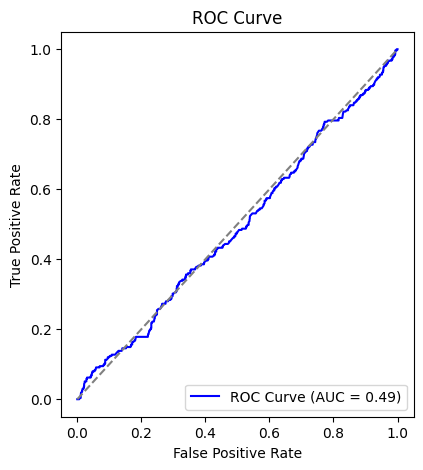

In [ ]:
#파라미터 수정3 pca차원 축소 사용 X
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# XGBoost 모델 생성
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid={
    'max_depth' : [3, 5, 7, 10],
    'n_estimators' : [50, 100, 200, 300, 400],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'gamma' : [0, 0.5, 1, 2],
    'colsample_bytree' : [0.5, 0.7, 0.9],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# GridSearchCV 실행
try:
    grid_search.fit(X_train_scaled, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

# 최적의 모델로 업데이트
    xgb_model = grid_search.best_estimator_
    y_pred_xgb = xgb_model.predict(X_test_scaled)

    print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
except Exception as e:
    print("An error occurred during GridSearchCV:", str(e))

# ROC Curve
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

xgb_model = XGBClassifier(objective='binary:logistic', eval_metric = 'auc', early_stopping_rounds=10)

param_grid_ = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid = param_grid_)

grid_search.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=0)

#최적의 모델로 예측
best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test_scaled)

print("Best parameters:", best_model)
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))


Best parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy Score: 0.8035714285714286


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import numpy as np

xgb_model = XGBClassifier(objective='binary:logistic')

param_grid_ = {
    'learning_rate': [0.01, 0.05, 0.1 , 1],
    'max_depth': [1, 3, 5, 10],
    'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

voting_cl = VotingClassifier(
    estimators = [('xgb', best_model)],
    voting = 'soft'
)

voting_cl.fit(X_train_scaled, y_train)

#최적의 모델로 예측
y_pred_xgb = voting_cl.predict(X_test_scaled)

print("Best parameters:", best_model)
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))


Best parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Accuracy Score: 0.8035714285714286


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

xgb_model = XGBClassifier(objective='binary:logistic', eval_metric = 'auc',  early_stopping_rounds=10)

xgb_param_grid={
    'max_depth' : [3, 5, 7, 10],
    'n_estimators' : [50, 100, 200, 300, 400],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'gamma' : [0, 0.5, 1, 2],
    'colsample_bytree' : [0.5, 0.7, 0.9],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid = param_grid_)

grid_search.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

#최적의 모델로 예측
best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))

Accuracy Score: 0.8035714285714286


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

xgb_model = XGBClassifier(objective='binary:logistic')

xgb_param_grid={
    'max_depth' : [3, 5, 7, 10],
    'n_estimators' : [50, 100, 200, 300, 400],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'gamma' : [0, 0.5, 1, 2],
    'colsample_bytree' : [0.5, 0.7, 0.9],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid = xgb_param_grid)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test_scaled)

print("Best parameters:", best_model)
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))



Best parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy Score: 0.8035714285714286


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)


xgb_model = XGBClassifier(objective='binary:logistic',
                          max_depth=5,
                          n_estimators=200,
                          learning_rate=0.1,
                          gamma=0.5,
                          colsample_bytree=0.7
)

xgb_model.fit(X_train_scaled, y_train, verbose=False)

#최적의 모델로 예측
y_pred_xgb = xgb_model.predict(X_test_scaled)

y_pred_xgb = xgb_model.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))


Accuracy Score: 0.8028571428571428


In [ ]:
# 모델 평가
print("XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1125
           1       0.00      0.00      0.00       275

    accuracy                           0.80      1400
   macro avg       0.40      0.50      0.45      1400
weighted avg       0.65      0.80      0.72      1400

[[1125    0]
 [ 275    0]]


**RandomForestClassifier**

 RandomForestClassifier 분류기 정확도 0.7964


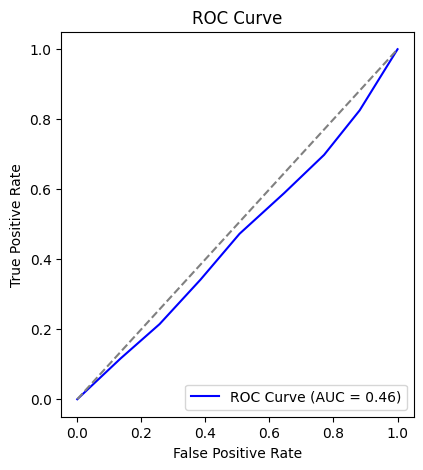

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1125
           1       0.19      0.01      0.02       275

    accuracy                           0.80      1400
   macro avg       0.50      0.50      0.45      1400
weighted avg       0.68      0.80      0.72      1400

[[1112   13]
 [ 272    3]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier # 솔직히 랜덤포레스트 있어야 하는지 모르겠는데 혹시 사용할 수도 있어서 일단 임포트
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Random Forest 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # 100개의 결정 트리로 모델 생성

# 모델 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

print(" RandomForestClassifier 분류기 정확도 {0:.4f}".format(accuracy_score(y_test, y_pred)))

# ROC Curve
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) #사이즈 줄임
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# 모델 평가
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

 RandomForestClassifier 분류기 정확도 0.8036


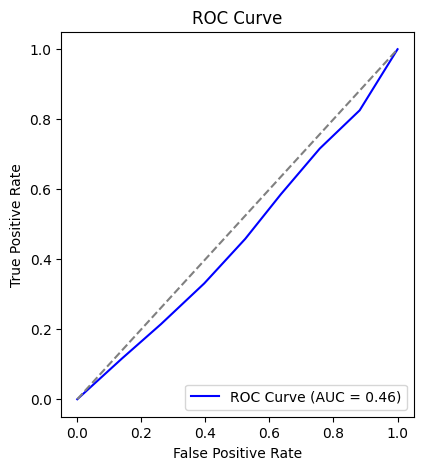

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1125
           1       0.00      0.00      0.00       275

    accuracy                           0.80      1400
   macro avg       0.40      0.50      0.45      1400
weighted avg       0.65      0.80      0.72      1400

[[1125    0]
 [ 275    0]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier # 솔직히 랜덤포레스트 있어야 하는지 모르겠는데 혹시 사용할 수도 있어서 일단 임포트
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Random Forest 모델 생성
rf_model = RandomForestClassifier(n_estimators=1000,
                                  max_depth=12,
                                  min_samples_split=8,
                                  min_samples_leaf=8,
                                  random_state=42) # 100개의 결정 트리로 모델 생성

# 모델 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

print(" RandomForestClassifier 분류기 정확도 {0:.4f}".format(accuracy_score(y_test, y_pred)))

# ROC Curve
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) #사이즈 줄임
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# 모델 평가
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

 RandomForestClassifier 분류기 정확도 0.8036


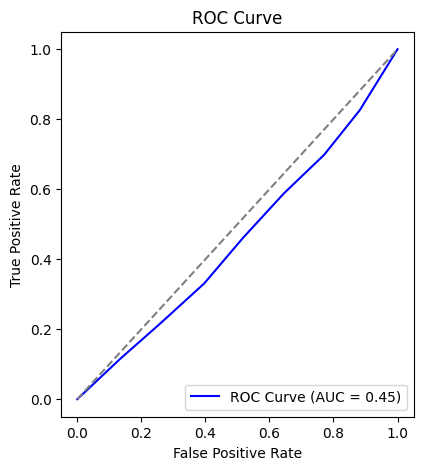

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1125
           1       0.00      0.00      0.00       275

    accuracy                           0.80      1400
   macro avg       0.40      0.50      0.45      1400
weighted avg       0.65      0.80      0.72      1400

[[1125    0]
 [ 275    0]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier # 솔직히 랜덤포레스트 있어야 하는지 모르겠는데 혹시 사용할 수도 있어서 일단 임포트
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Random Forest 모델 생성
rf_model = RandomForestClassifier(n_estimators=2000,
                                  max_depth=2,
                                  min_samples_split=8,
                                  min_samples_leaf=8,
                                  random_state=42) # 100개의 결정 트리로 모델 생성

# 모델 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

print(" RandomForestClassifier 분류기 정확도 {0:.4f}".format(accuracy_score(y_test, y_pred)))

# ROC Curve
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) #사이즈 줄임
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# 모델 평가
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

**voting**

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



#weak learners: logistic regression, KNN
logistic_regression = LogisticRegression()
KNN = KNeighborsClassifier()

#votinng ensemble with these two weak learners
voting_ensemble = VotingClassifier(estimators=[("LogisticRegression", logistic_regression), ("KNN", KNN)],
                                  voting = 'soft')

# voting_ensemble model train/val/test
voting_ensemble.fit(X_train_scaled, y_train)
y_pred = voting_ensemble.predict(X_test_scaled)

print("voting 분류기 정확도 {0:.4f}".format(accuracy_score(y_test, y_pred)))

voting 분류기 정확도 0.8036


voting 분류기 정확도 0.8029


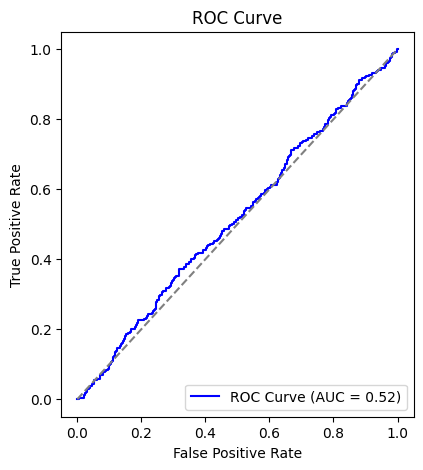

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score


#weak learners: logistic regression, KNN
logistic_regression = LogisticRegression()
KNN = KNeighborsClassifier()

#votinng ensemble with these two weak learners
voting_ensemble = VotingClassifier(estimators=[("LogisticRegression", logistic_regression), ("KNN", KNN)],
                                  voting = 'soft')

# voting_ensemble model train/val/test
voting_ensemble.fit(X_train_scaled, y_train)
y_pred = voting_ensemble.predict(X_test_scaled)

print("voting 분류기 정확도 {0:.4f}".format(accuracy_score(y_test, y_pred)))

# ROC Curve
y_pred_proba = voting_ensemble.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) #사이즈 줄임
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**LGBMClassifier**

[LightGBM] [Info] Number of positive: 1104, number of negative: 4496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197143 -> initscore=-1.404248
[LightGBM] [Info] Start training from score -1.404248


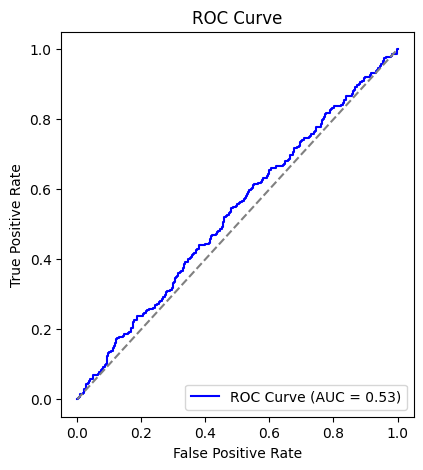

LightGBM Model Performance:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1125
           1       0.31      0.01      0.03       275

    accuracy                           0.80      1400
   macro avg       0.56      0.50      0.46      1400
weighted avg       0.71      0.80      0.72      1400

[[1116    9]
 [ 271    4]]


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 데이터 분할 (이미 수행했다면 이 단계는 건너뛰세요)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(n_estimators=100 , random_state=42)

# 모델 학습
lgbm_model.fit(X_train_scaled, y_train)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# ROC Curve
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lgbm)
roc_auc = roc_auc_score(y_test, y_pred_proba_lgbm)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) #사이즈 줄임
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# 모델 평가
print("LightGBM Model Performance:")
print(classification_report(y_test, y_pred_lgbm))
print(confusion_matrix(y_test, y_pred_lgbm))

**DecisionTree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 알고리즘
dtree = DecisionTreeClassifier()

dtree_param_grid={
    'max_depth' : [1,2,3],
    'min_samples_split' : [2,3,4],

}

grid_dtree= GridSearchCV(dtree, param_grid=dtree_param_grid ,cv=5, refit=True)

grid_dtree.fit(X_train_scaled, y_train)

print("Best parameters:", grid_dtree.best_params_)
print("Best cross-validation score:", grid_dtree.best_score_)

# 최적의 모델로 예측
best_model = grid_dtree.best_estimator_
y_pred_xgb = best_model.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))

Best parameters: {'max_depth': 1, 'min_samples_split': 2}
Best cross-validation score: 0.8028571428571428
Accuracy Score: 0.8035714285714286


In [ ]:
#decision tree 수정1

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 알고리즘
dtree = DecisionTreeClassifier()

dtree_param_grid={
    'max_depth' : [0.1, 0.5, 1, 2],
    'min_samples_split': [0.1, 2, 5],

}

grid_dtree= GridSearchCV(dtree, param_grid=dtree_param_grid ,cv=5, refit=True)

grid_dtree.fit(X_train_scaled, y_train)

print("Best parameters:", grid_dtree.best_params_)
print("Best cross-validation score:", grid_dtree.best_score_)

# 최적의 모델로 예측
best_model = grid_dtree.best_estimator_
y_pred_dtree = best_model.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_pred_dtree))

Best parameters: {'max_depth': 1, 'min_samples_split': 0.1}
Best cross-validation score: 0.8028571428571428
Accuracy Score: 0.8035714285714286


In [ ]:
#decision tree 수정2
from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 알고리즘
dtree = DecisionTreeClassifier(max_depth=1, random_state=42)

dtree.fit(X_train_scaled, y_train)

pred = dtree.predict(X_test_scaled)
accuracy = accuracy_score(y_test, pred)
print('예측 정확도 : ' + str(accuracy))



예측 정확도 : 0.8035714285714286


In [ ]:
#decision tree 수정3
from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 알고리즘
dtree = DecisionTreeClassifier(max_depth=1, random_state=100)

dtree.fit(X_train_scaled, y_train)

pred = dtree.predict(X_test_scaled)
accuracy = accuracy_score(y_test, pred)
print('예측 정확도 : ' + str(accuracy))



예측 정확도 : 0.8035714285714286


Best parameters: {'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 2}
Best cross-validation score: 0.8028571428571428
Accuracy Score: 0.8035714285714286


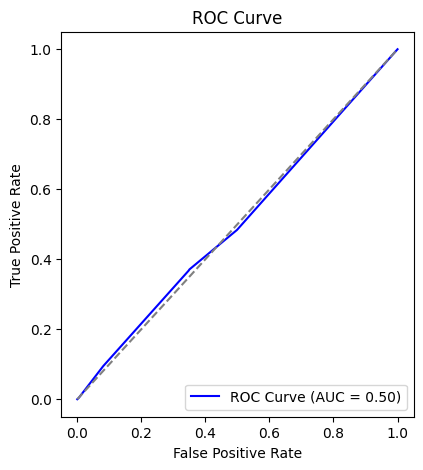

In [ ]:
#decision tree 수정3
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 알고리즘
dtree = DecisionTreeClassifier(max_depth=1, random_state=100)

dtree_param_grid={
    'max_depth' : [3,5,7,10,None],
    'min_samples_split': [1,2,4,8],
    'min_samples_leaf': [10,20]

}

grid_dtree= GridSearchCV(dtree, param_grid=dtree_param_grid ,cv=5, scoring='accuracy')

grid_dtree.fit(X_train_scaled, y_train)

print("Best parameters:", grid_dtree.best_params_)
print("Best cross-validation score:", grid_dtree.best_score_)

# 최적의 모델로 예측
best_model = grid_dtree.best_estimator_
y_pred_dtree = best_model.predict(X_test_scaled)

# ROC Curve
y_prob_lr = grid_dtree.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = roc_auc_score(y_test, y_prob_lr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

print("Accuracy Score:", accuracy_score(y_test, y_pred_dtree))



Accuracy Score: 0.8035714285714286


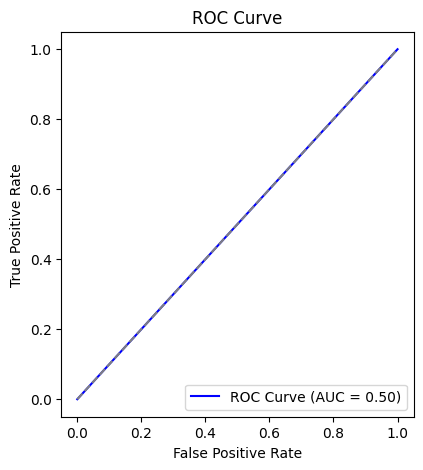

In [ ]:
#decision tree 수정3
from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np


# 알고리즘
dtree = DecisionTreeClassifier(max_depth=5,
                               min_samples_leaf=10,
                               min_samples_split=2,
                               random_state=100)


dtree.fit(X_train_scaled, y_train)

# 예측
y_pred = rf_model.predict(X_test_scaled)


# ROC Curve
y_prob_lr = dtree.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

print("Accuracy Score:", accuracy_score(y_test, y_pred_dtree))



**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=42)

#try1
lr_params = {
    'c' : [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty' : ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'max_iter': [50, 150, 200]
}

grid_lr = GridSearchCV(lr_model, param_grid=lr_params, cv=5, scoring='accuracy')

# 모델 학습
grid_lr.fit(X_train_scaled, y_train)

#print("Best parameters:", grid_lr.best_params_)
#print("Best cross-validation score:", grid_lr.best_score_)

# 예측
best_model = grid_lr.best_estimator_
y_pred_lr = best_model.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))


Accuracy Score: 0.8035714285714286


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=42)

#try2
lr_params = {
    'c' : [0.05, 0.1, 1.5, 2.0],
    'penalty' : ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'max_iter': [150, 300, 500]
}

grid_lr = GridSearchCV(lr_model, param_grid=lr_params, cv=5, scoring='accuracy')

# 모델 학습
grid_lr.fit(X_train_scaled, y_train)

#print("Best parameters:", grid_lr.best_params_)
#print("Best cross-validation score:", grid_lr.best_score_)

# 예측
best_model = grid_lr.best_estimator_
y_pred_lr = best_model.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))


Accuracy Score: 0.8035714285714286


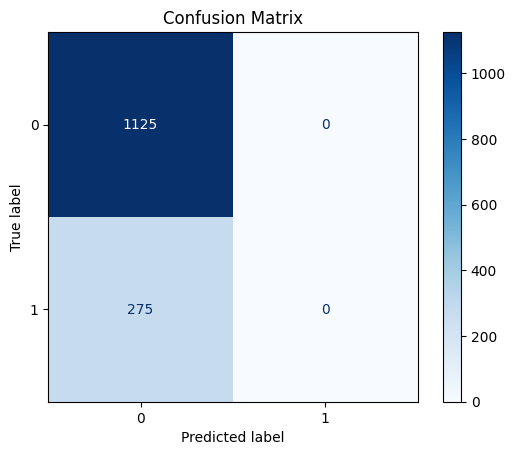

accuracy :  0.8035714285714286


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

#GridSearchCV X
lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Confusion Matrix 생성 및 시각화
conf_matrix = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)  # 시각화 스타일 선택
plt.title("Confusion Matrix")
plt.show()

# accuracy 구하기
print("accuracy : ", accuracy_score(y_test, y_pred_lr))

▲ We don't really know why the Confusion Matrix is like this.. so We want a lot of advice

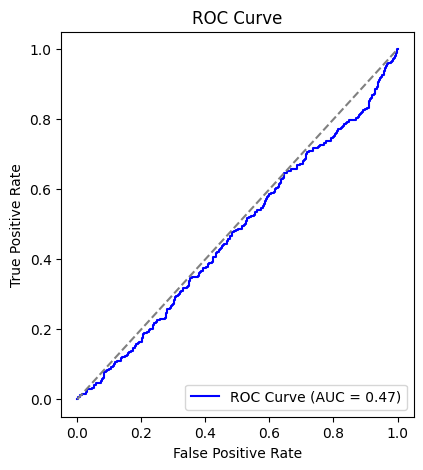

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

# ROC Curve
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]  # 클래스 확률
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = roc_auc_score(y_test, y_prob_lr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")


Test Accuracy: 80.36%


Text(0.5, 1.0, 'Confusion Matrix')

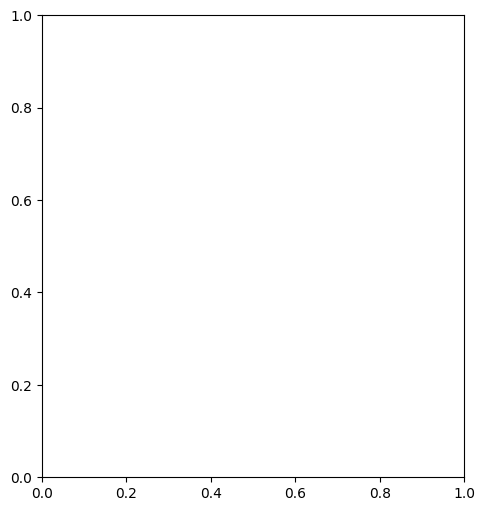

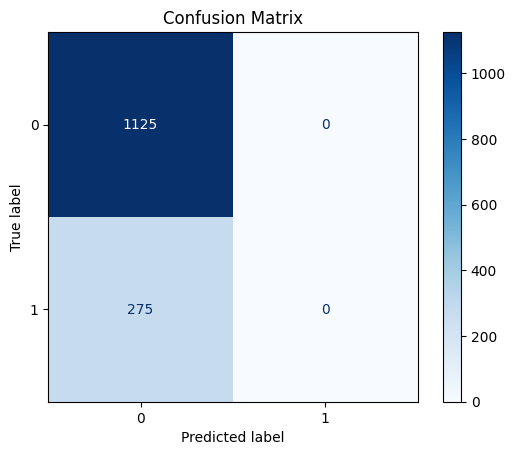

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score,  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)


y_pred_lr = model.predict(X_test_scaled)
prob = model.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred_lr)
print(f'Test Accuracy: {acc * 100:.2f}%')


# 1. Confusion Matrix 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_estimator(lr, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")




In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model = KNeighborsClassifier()

cv_score = cross_val_score(model, X_train_scaled, y_train, cv=10)
print(cv_score)
print(cv_score.mean())


[0.7625     0.78035714 0.76785714 0.775      0.77857143 0.78035714
 0.77857143 0.78035714 0.76964286 0.76964286]
0.7742857142857142


In [ ]:
import pickle

# 모델에 특성 이름 저장 (모델 훈련 후)
feature_names = X.columns.tolist()

# 모델과 특성 이름을 함께 저장
with open('logistic_model.pkl', 'wb') as file:
    pickle.dump((model, feature_names), file)

# 스케일러 저장
with open('lr_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
